# Simple Spam Detection Project


### About Dataset:

This dataset consists of 5,573 emails, each labeled as either spam or ham (not spam). The dataset is available on Kaggle. 

The goal of this project is to preprocess the text data and explore various approaches to build an effective spam detection model.

_______________

## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import nltk
import re
import string
import joblib
from collections import Counter

from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize, WordPunctTokenizer, sent_tokenize, PunktSentenceTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tag import pos_tag

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, make_scorer


nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Load Dataset

In [2]:
# Load dataset
df = pd.read_csv('datasets-spam.csv', encoding = 'latin-1')

# concat text in one column
df['v2'] = df['v2'] + ' ' + df['Unnamed: 2'].fillna('') + ' ' + df['Unnamed: 3'].fillna('') + ' ' + df['Unnamed: 4'].fillna('')

# drop remaining columns
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

#rename
df.rename(columns={'v1': 'is_spam', 'v2': 'text'}, inplace=True)

df.head()

,is_spam,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Analysis

In [3]:
# Shape
df.shape

(5572, 2)

In [4]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   is_spam  5572 non-null   object
 1   text     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
# Missing values and duplicates
print(f'There are {df.isna().sum().sum()} missing values')

There are 0 missing values


In [6]:
# Duplicates
print(f'There are {df.duplicated().sum()} duplicates in this dataset\n')

df[df.duplicated(subset='text')]

There are 403 duplicates in this dataset



,is_spam,text
102,ham,As per your request 'Melle Melle (Oru Minnamin...
153,ham,As per your request 'Melle Melle (Oru Minnamin...
206,ham,"As I entered my cabin my PA said, '' Happy B'd..."
222,ham,"Sorry, I'll call later"
325,ham,No calls..messages..missed calls
...,...,...
5524,spam,You are awarded a SiPix Digital Camera! call 0...
5535,ham,"I know you are thinkin malaria. But relax, chi..."
5539,ham,Just sleeping..and surfing
5553,ham,Hahaha..use your brain dear


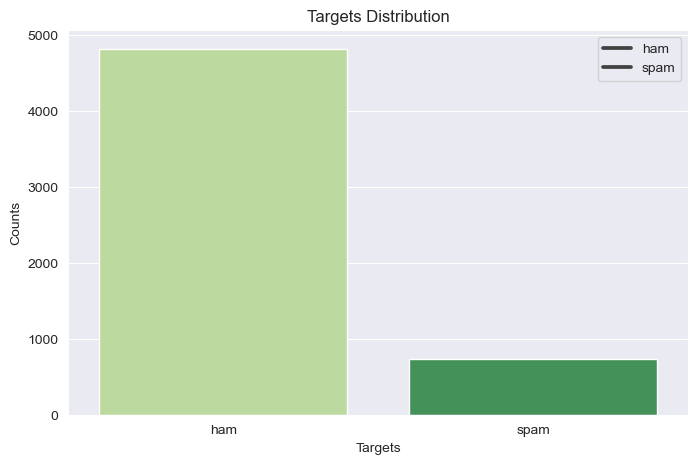

In [7]:
# Lets visualize targets counts
targets_counts = df['is_spam'].value_counts()
# print(targets_counts)

# Plot
plt.figure(figsize = (8,5))
sns.set_style('darkgrid')

sns.barplot(x = targets_counts.index, y = targets_counts.values, palette='YlGn')
plt.title('Targets Distribution')
plt.legend(['ham', 'spam'])
plt.xlabel('Targets')
plt.ylabel('Counts')

# show
plt.show()

### Conclusion from Analysis:
- **Dataset Overview**: Contains 5,572 text entries, categorized as **spam** or **ham** (non-spam).

- **Missing Values**: The dataset is free of missing values.

- **Duplicates**: There are duplicate entries, which will be addressed after text preprocessing.

- **Class Imbalance**: The dataset exhibits a class imbalance. While text data augmentation could be a solution, the initial strategy will involve improving model performance to manage the imbalance effectively.

_______________


## Text Preprocessing

In [8]:
# Defininf pos tags function (Part of speech tags)
def get_pos_tags(tag): 
    if tag.startswith("N"):
        return wordnet.NOUN
    if tag.startswith("J"):
        return wordnet.ADJ
    if tag.startswith("V"):
        return wordnet.VERB
    if tag.startswith("R"):
        return wordnet.ADV
    return wordnet.NOUN

In [9]:
# Preprocess Text

def preprocess_text(text):
    
    # lowercase
    text = text.lower()
    
    # remove punctuations
    text = text.translate(str.maketrans('','', string.punctuation))
    
    # tokenize
    tokens = word_tokenize(text)
    
    # remove stopwords and words with length lower than 3
    stop_words = set(stopwords.words('english'))
    words = [word for word in tokens if word not in stop_words and len(word) > 3]
    
    # Lemmatization
    lemma = WordNetLemmatizer()
    words = [lemma.lemmatize(word,pos=get_pos_tags(nltk.pos_tag(['working'])[0][1])) for word in words]
    
    # final
    texts = ' '.join(words)
    
    return texts

In [10]:
# Apply function

# Make copy of original df
data = df.copy()

tqdm.tqdm.pandas()
data['text'] = data['text'].progress_apply(preprocess_text)

100%|██████████| 5572/5572 [00:36<00:00, 153.54it/s]


In [11]:
print('Unprocessed text:', df['text'][4], '\n')
print('Processed text:', data['text'][4])

Unprocessed text: Nah I don't think he goes to usf, he lives around here though    

Processed text: dont think go live around though


**Note: we can see that these text are written in evryday language**

## Splitting Dataset

In [12]:
# Split on labels and text
texts = data['text']
labels = data['is_spam']

In [13]:
# Encoding Targets
le = LabelEncoder()

labels = le.fit_transform(labels)

print(labels) # 0 for ham, 1 for spam

[0 0 1 ... 0 0 0]


In [14]:
# Splitting on train and test
X_train,X_test,y_train,y_test = train_test_split(texts,labels, shuffle=True, stratify=labels,
                                                 random_state = 42,
                                                 test_size = 0.2)

# Shapes
print('Train Shape:', X_train.shape, y_train.shape)
print('Test Shape:', X_test.shape, y_test.shape)

Train Shape: (4457,) (4457,)
Test Shape: (1115,) (1115,)


In [15]:
# Labels counter
print('Train:', Counter(y_train))
print('Test:', Counter(y_test))

Train: Counter({0: 3859, 1: 598})
Test: Counter({0: 966, 1: 149})


## Feature Extraction

In [16]:
# CountVectorizer (BOW)
bow = CountVectorizer(min_df=1)

# fit
# bow.fit(data)
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

# shapes
print('Shape:', X_train_bow.shape)

Shape: (4457, 6589)


In [17]:
# Tf-IDF 

tfidf = TfidfVectorizer(min_df=1)

# fit
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# shapes
print('Shape:', X_train_tfidf.shape)

Shape: (4457, 6589)


**Note: because number of features is higher than the number of instances, using min_df will help. I will try both approaches and see if something changes**

## Model Training and Evaluating

#### Using models with default parameters

In [18]:
# Define models
lr = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
svc = SVC(random_state=42)
gaussian = MultinomialNB()

models = [lr, rf, svc, gaussian]
model_names = ['lr', 'rf', 'svc', 'gaussian']

In [19]:
# Define function
def train_model(model,model_name,X_train,y_train,X_test,y_test):
    
    results = []
    
    # fit
    model.fit(X_train, y_train)
    
    # predict
    y_predict = model.predict(X_test)
    
    # score
    accuracy = accuracy_score(y_test,y_predict)
    f1 = f1_score(y_test,y_predict)
    recall = recall_score(y_test,y_predict)
    precision = precision_score(y_test, y_predict)
    
    # append results
    results.append({'model': model_name, 
                    'accuracy': accuracy, 
                    'f1':f1, 
                    'recall':recall, 
                    'precision':precision})
    
    # confusion matrix
    cf = confusion_matrix(y_test,y_predict)

    # Plot confusion matrix
    plt.figure(figsize=(6, 3))
    sns.heatmap(cf, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    return results

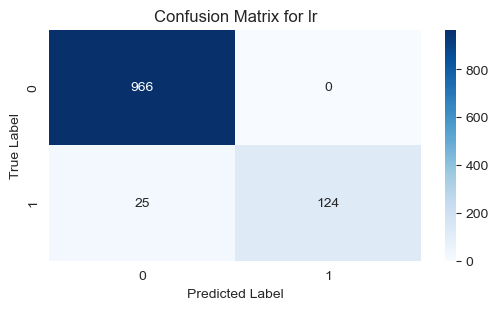

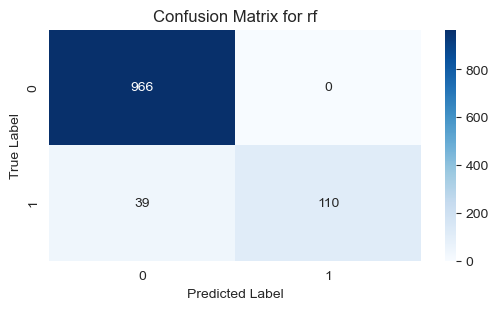

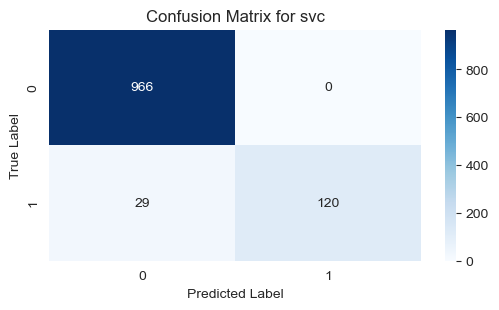

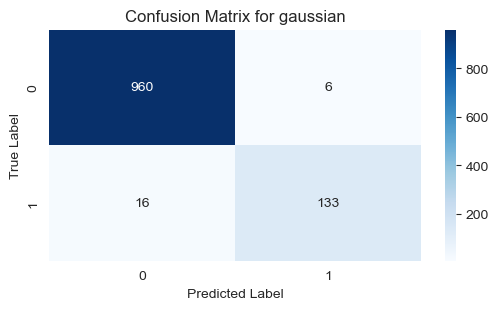

,model,accuracy,f1,recall,precision
0,lr,0.977578,0.908425,0.832215,1.000000
1,rf,0.965022,0.849421,0.738255,1.000000
2,svc,0.973991,0.892193,0.805369,1.000000
3,gaussian,0.980269,0.923611,0.892617,0.956835


In [20]:
# For BOW

# define list to store final results
bow_results = []

# Loop through every model and call the function
for model, model_name in zip(models, model_names):
    results = train_model(model, model_name, X_train_bow,y_train,X_test_bow,y_test)
    bow_results.extend(results)

# Display results
bow_results_df = pd.DataFrame(bow_results)
bow_results_df

### Conclusion from Model Training using Count Vectorizer (Bag of Words)


Based on the evaluation of the models, **MultinomialNB** stands out as the top performer with the following metrics:

- **Accuracy:** 98%
- **F1 Score:** 92.4%

However, the confusion matrix indicates that **MultinomialNB** has some drawbacks, including:
- **False Positives:** 6 emails incorrectly classified as spam
- **False Negatives:** 16 emails incorrectly classified as not spam

If minimizing false positives is a higher priority, **Logistic Regression** is the preferable model:

- **Accuracy:** 97.7%
- **F1 Score:** 90.8%
- **False Positives:** 0
- **False Negatives:** 25

Although **Logistic Regression** has slightly lower accuracy and F1 score compared to **MultinomialNB**, it excels in avoiding false positives, making it a better choice for scenarios where reducing false spam detections is crucial.

**Additional Notes:**
- None of the models were hyper-tuned (i.e., default parameters were used).
- An attempt was made to use `min_df=2` to reduce the number of instances. However, this adjustment led to worse predictions.


#### Using Tf-IDF

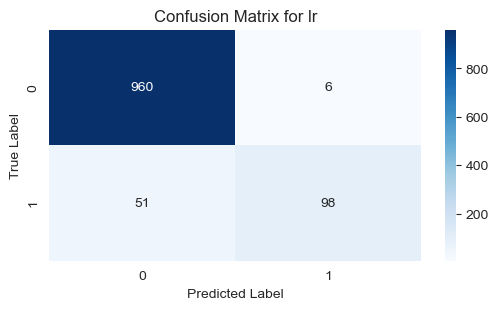

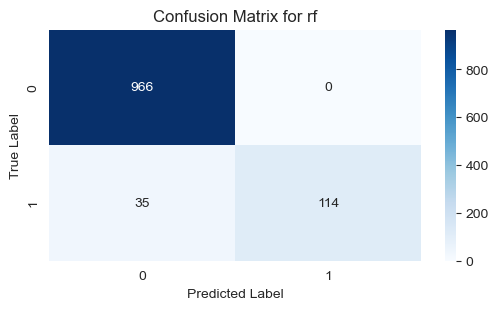

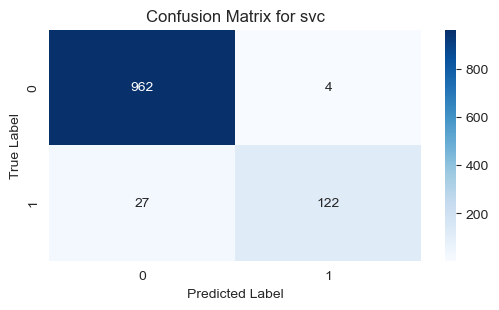

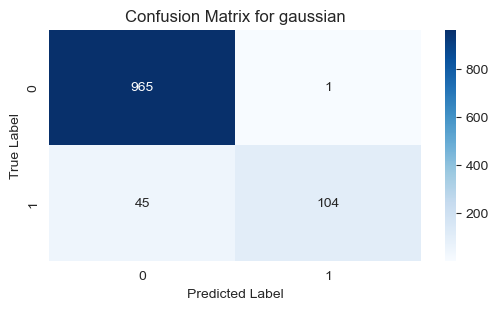

,model,accuracy,f1,recall,precision
0,lr,0.948879,0.774704,0.657718,0.942308
1,rf,0.968610,0.866920,0.765101,1.000000
2,svc,0.972197,0.887273,0.818792,0.968254
3,gaussian,0.958744,0.818898,0.697987,0.990476


In [21]:
tfidf_results = []

for model, model_name in zip(models, model_names):
    results = train_model(model, model_name, X_train_tfidf,y_train,X_test_tfidf,y_test)
    tfidf_results.extend(results)
    
tfidf_results_df = pd.DataFrame(tfidf_results)
tfidf_results_df

### Conclusion from Model Training using TF-IDF

In the evaluation of models trained with TF-IDF, **SVC (Support Vector Classifier)** demonstrates the best performance:

- **Accuracy:** 97.2%
- **F1 Score:** 88.7%
- **False Positives:** 4
- **False Negatives:** 27

While **SVC** achieves the highest accuracy and F1 score, it does have some false positives and false negatives.

If the primary goal is to eliminate false positives, **Random Forest** emerges as the best choice:

- **Accuracy:** 96.8%
- **F1 Score:** 86.6%
- **False Positives:** 0
- **False Negatives:** 35

**Random Forest** does not produce any false positives, making it ideal for scenarios where avoiding false spam detections is crucial, despite having a slightly lower accuracy and F1 score compared to **SVC**.

**Additional Notes:**
- None of the models underwent hyperparameter optimization (default parameters were used).


## Model Training and Hyperparameter Optimization

In [27]:
# Define params grid
params_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10],
                  'penalty': ['l1', 'l2'],
                  'solver': ['liblinear', 'saga'],
                  'class_weight': [None, 'balanced']}

params_grid_rf = {'n_estimators' : [5,10,15,20],
                  'max_depth': [2,4,5,10],
                  'criterion': ['gini'],
                  'min_samples_split' : [2,3],
                  'min_samples_leaf' : [1,2],
                  'class_weight' : ['balanced'],
                  'random_state' : [42]}

params_grid_svc = {'kernel' : ['linear', 'poly', 'rbf'],
                  'degree': [2,3,4],
                  'C': [0.01,0.05,0.1,0.5,1],
                  'class_weight' : ['balanced'],
                  'random_state' : [42]}

params_grid_nb = {'alpha': [0.1, 0.5, 1.0, 2.0],
                  'fit_prior': [True, False]}

params = [params_grid_lr,params_grid_rf,params_grid_svc,params_grid_nb]

In [23]:
# Define gridsearch function
def gridsearch_params(model,model_name,params, X_train,y_train,X_test,y_test):
    report = []
    
    print('\nCurrently fitting model:', model_name, '\n')
    
    # define kfold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # define grid
    grid_cv = GridSearchCV(model,params,cv=kf,n_jobs=-1, verbose=1, refit=True, scoring='f1_macro')
    
    #fit
    grid_cv.fit(X_train,y_train)
    
    # print the best score and parameters
    best_score = grid_cv.best_score_
    best_params = grid_cv.best_params_
    
    print(f'Best Score:', best_score)
    print('Best Params:', best_params)
    
    # cppend results
    results = {'model': model_name,
              'best_score': best_score}
    
    report.append(results)
    
    return report

In [24]:
# Train and tune parameters using BOW
report_bow = []

for model, model_name, params in zip(models, model_names, params):
    results = gridsearch_params(model, model_name,params, X_train_bow,y_train,X_test_bow,y_test)
    report_bow.extend(results)
    
# display results in df    
report_bow_df = pd.DataFrame(report_bow)
report_bow_df


Currently fitting model: lr 

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Score: 0.9543307174583375
Best Params: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

Currently fitting model: rf 

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Score: 0.89102630110029
Best Params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20, 'random_state': 42}

Currently fitting model: svc 

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best Score: 0.9481286095139263
Best Params: {'C': 0.1, 'class_weight': 'balanced', 'degree': 2, 'kernel': 'linear', 'random_state': 42}

Currently fitting model: gaussian 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Score: 0.9471769494116437
Best Params: {'alpha': 2.0, 'fit_prior': True}


,model,best_score
0,lr,0.954331
1,rf,0.891026
2,svc,0.948129
3,gaussian,0.947177


In [28]:
# Train and tune parameters using TFIDF
report_tfidf = []

for model, model_name, params in zip(models, model_names, params):
    results = gridsearch_params(model, model_name,params, X_train_tfidf,y_train,X_test_tfidf,y_test)
    report_tfidf.extend(results)

# display results in df    
report_tfidf_df = pd.DataFrame(report_tfidf)
report_tfidf_df


Currently fitting model: lr 

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Score: 0.939740920837913
Best Params: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}

Currently fitting model: rf 

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Score: 0.894884769622301
Best Params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20, 'random_state': 42}

Currently fitting model: svc 

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best Score: 0.9347520451494497
Best Params: {'C': 0.5, 'class_weight': 'balanced', 'degree': 2, 'kernel': 'linear', 'random_state': 42}

Currently fitting model: gaussian 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Score: 0.9464267678937827
Best Params: {'alpha': 0.1, 'fit_prior': True}


,model,best_score
0,lr,0.939741
1,rf,0.894885
2,svc,0.934752
3,gaussian,0.946427


#### Evaluate using best models

Accuracy score : 0.98
F1 score : 0.94
Recall Score : 0.91
Precision Score : 0.98


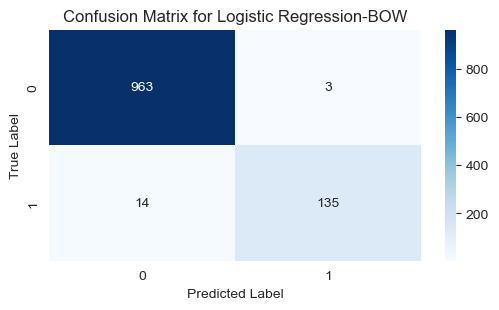

In [25]:
# Load best model
best_model_bow = LogisticRegression(C=10, class_weight='balanced', penalty = 'l2', solver = 'liblinear')

# fit
best_model_bow.fit(X_train_bow,y_train)

# Evaluate
y_predicted = best_model_bow.predict(X_test_bow)

# Score
accuracy = accuracy_score(y_test,y_predicted)
f1 = f1_score(y_test,y_predicted)
recall = recall_score(y_test,y_predicted)
precision = precision_score(y_test, y_predicted)

print('Accuracy score :', np.round(accuracy,2))
print('F1 score :', np.round(f1,2))
print('Recall Score :', np.round(recall,2))
print('Precision Score :', np.round(precision,2))

# confusion matrix
cf = confusion_matrix(y_test,y_predicted)

# Plot confusion matrix
plt.figure(figsize=(6, 3))
sns.heatmap(cf, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title(f'Confusion Matrix for Logistic Regression-BOW')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Accuracy score : 0.98
F1 score : 0.91
Recall Score : 0.86
Precision Score : 0.97


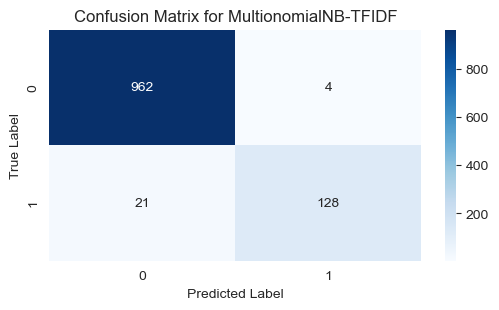

In [29]:
# Load best model
best_model_tfidf = MultinomialNB(alpha=0.1, fit_prior=True)

# fit
best_model_tfidf.fit(X_train_tfidf,y_train)

# Evaluate
y_predicted = best_model_tfidf.predict(X_test_tfidf)

# Score
accuracy = accuracy_score(y_test,y_predicted)
f1 = f1_score(y_test,y_predicted)
recall = recall_score(y_test,y_predicted)
precision = precision_score(y_test, y_predicted)

print('Accuracy score :', np.round(accuracy,2))
print('F1 score :', np.round(f1,2))
print('Recall Score :', np.round(recall,2))
print('Precision Score :', np.round(precision,2))

# confusion matrix
cf = confusion_matrix(y_test,y_predicted)

# Plot confusion matrix
plt.figure(figsize=(6, 3))
sns.heatmap(cf, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title(f'Confusion Matrix for MultionomialNB-TFIDF')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [31]:
# Save best model
joblib.dump(best_model_bow, 'best_model_spam_detection.pkl')

['best_model_spam_detection.pkl']

## Prediction

In [33]:
# Load best model
best_model = joblib.load('best_model_spam_detection.pkl')
best_model

LogisticRegression(C=10, class_weight='balanced', solver='liblinear')

In [34]:
# Load random text sample
text_sample =[ '''Congratulations! You've Won a Free Vacation

              Dear Valentina,

              We are thrilled to inform you that you have been selected as the lucky winner of our exclusive vacation giveaway!
              You and a companion are entitled to a luxurious 5-day, 4-night stay at a world-class resort in the Caribbean.

              To claim your prize, simply click on the link below and provide us with your contact details within the next 24 hours:

              But hurry, this offer is only available for a limited time! Don't miss out on this amazing opportunity to enjoy a dream vacation on us.

              Best regards,
              Vavilon Hotel''']

In [41]:
# Apply preprocessing steps
preprocessed_text_sample = preprocess_text(text_sample[0])

In [44]:
# Apply bow vectorizer
preprocessed_text_sample = bow.transform([preprocessed_text_sample])
preprocessed_text_sample.shape

(1, 6589)

In [48]:
# Predict
y_pred = best_model.predict_proba(preprocessed_text_sample)
print('Probability of this message to be ham:', y_pred[0][0])
print('Probability of this message to be spam:', y_pred[0][1])

Probability of this message to be ham: 7.522756029221256e-08
Probability of this message to be spam: 0.9999999247724397


## Final Conclusion

After performing hyperparameter tuning, i have determined that the best results, based on the highest F1 score, were achieved using **Logistic Regression** with **Bag of Words** (BoW) feature extraction. The key metrics for this model are as follows:

- **Accuracy Score**: 0.98
- **F1 Score**: 0.94
- **Recall Score**: 0.91
- **Precision Score**: 0.98

Additionally, the model's performance in terms of misclassifications is:

- **False Negatives**: 14
- **False Positives**: 3

The model was also tested on a sample of text, and it correctly predicted the sample with a 0.99 probability of being spam.

**Note**: The texts used in this analysis are written in everyday conversational language, with informal expressions and shorthand. This could impact the model's performance. To potentially improve results, incorporating more diverse texts and enhancing text cleaning processes may be beneficial.

This indicates that Logistic Regression with BoW feature extraction offers the best balance between precision and recall for this task, making it the most effective model among those tested.
